# League of Legends Win Prediction with XGBoost

This notebook uses the Kaggle dataset [League of Legends Ranked Matches](https://www.kaggle.com/paololol/league-of-legends-ranked-matches) which contains 180,000 ranked games of League of Legends starting from 2014. Using this data we build an XGBoost model to predict if a player's team will win based on statistics about how that player played the match.

The methods used here are applicable to any dataset. We use this dataset to illustrate how SHAP values help make gradient boosted trees such as XGBoost interpretable. Due to the size, interaction effections, containing both catgoriacl and continuous features and its interpretability (particularly for players of the game) the dataset suits as a good example on various fronts. For more information on SHAP values see: https://github.com/shap/shap 

In [2]:
from pathlib import Path

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scipy as sp
import xgboost as xgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import shap
import time

shap.initjs()

## Load the dataset

To run this yourself you will need to download the dataset from Kaggle and ensure the `prefix` variable below is correct. To do so follow the link given above and download and extract the data. Change the `prefix` variable if needed.

In [4]:
# read in the 
folder_path = "C:\\Users\\azabe\\Downloads\\archive"
matches_file = folder_path + "\\matches.csv"
participants_file = folder_path + "\\participants.csv"
stats1_file = folder_path + "\\stats1.csv"
stats2_file =folder_path + "\\stats2.csv"


matches = pd.read_csv(matches_file)
participants = pd.read_csv(participants_file)
stats1 = pd.read_csv(stats1_file, low_memory=False)
stats2 = pd.read_csv(stats2_file, low_memory=False)
stats = pd.concat([stats1, stats2])

# merge into a single DataFrame
a = pd.merge(
    participants, matches, left_on="id", right_on="id", suffixes=("", "_matches")
)
allstats_orig = pd.merge(
    a, stats, left_on="id", right_on="id", suffixes=("", "_stats")
)
allstats = allstats_orig.copy()

# drop games that lasted less than 10 minutes
allstats = allstats.loc[allstats["duration"] >= 10 * 60, :]

# Convert string-based categories to numeric values
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype("category")
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

X = allstats.drop(columns=["win"])
y = allstats["win"]

# convert all features we want to consider as rates
rate_features = [
    "kills",
    "deaths",
    "assists",
    "killingsprees",
    "doublekills",
    "triplekills",
    "quadrakills",
    "pentakills",
    "legendarykills",
    "totdmgdealt",
    "magicdmgdealt",
    "physicaldmgdealt",
    "truedmgdealt",
    "totdmgtochamp",
    "magicdmgtochamp",
    "physdmgtochamp",
    "truedmgtochamp",
    "totheal",
    "totunitshealed",
    "dmgtoobj",
    "timecc",
    "totdmgtaken",
    "magicdmgtaken",
    "physdmgtaken",
    "truedmgtaken",
    "goldearned",
    "goldspent",
    "totminionskilled",
    "neutralminionskilled",
    "ownjunglekills",
    "enemyjunglekills",
    "totcctimedealt",
    "pinksbought",
    "wardsbought",
    "wardsplaced",
    "wardskilled",
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60  # per minute rate

# convert to fraction of game
X["longesttimespentliving"] /= X["duration"]

# define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets",
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

# create train/validation split
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

In [5]:
len(X.columns)

69

## Train the XGBoost model

In [7]:
params = {
    "objective": "binary:logistic",
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
}
model = xgb.train(
    params,
    dt,
    num_boost_round=10,
    evals=[(dt, "train"), (dv, "valid")],
    early_stopping_rounds=5,
    verbose_eval=25,
)

[0]	train-logloss:0.57211	valid-logloss:0.57507
[9]	train-logloss:0.34310	valid-logloss:0.35730


## Explain the XGBoost model

Because the Tree SHAP algorithm is implemented in XGBoost we can compute exact SHAP values quickly over thousands of samples. The SHAP values for a single prediction (including the expected output in the last column) sum to the model's output for that prediction.

In [9]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

In [10]:
partition_tree = {
    'cluster_1': {
        'Game Information': {
            'Identifiers': {
                'id': 'id',
                'matchid': 'matchid',
                'gameid': 'gameid',
                'platformid': 'platformid'
            },
            'Context': {
                'queueid': 'queueid',
                'seasonid': 'seasonid'
            },
            'Timing': {
                'creation': 'creation',
                'version': 'version',
                'duration': 'duration'
            }
        },
        'Player Information': {
            'Player Metadata': {
                'player': 'player',
                'championid': 'championid'
            },
            'Summoner Spells': {
                'ss1': 'ss1',
                'ss2': 'ss2'
            },
            'Role and Position': {
                'role': 'role',
                'position': 'position'
            }
        }
    },
    'cluster_2': {
        'Items': {
            'Main Items': {
                'item1': 'item1',
                'item2': 'item2',
                'item3': 'item3',
                'item4': 'item4',
                'item5': 'item5',
                'item6': 'item6'
            },
            'Trinket': {
                'trinket': 'trinket'
            }
        },
        'Kills and Deaths': {
            'Kill Metrics': {
                'Kills per min.': 'Kills per min.',
                'largestkillingspree': 'largestkillingspree',
                'largestmultikill': 'largestmultikill',
                'Killing sprees per min.': 'Killing sprees per min.',
                'Double kills per min.': 'Double kills per min.',
                'Triple kills per min.': 'Triple kills per min.',
                'Quadra kills per min.': 'Quadra kills per min.',
                'Penta kills per min.': 'Penta kills per min.',
                'Legendary kills per min.': 'Legendary kills per min.'
            },
            'Death Metrics': {
                'Deaths per min.': 'Deaths per min.'
            },
            'Assist Metrics': {
                'Assists per min.': 'Assists per min.'
            },
            'Survival Metrics': {
                'Longest time living as % of game': 'Longest time living as % of game'
            }
        }
    },
    'cluster_3': {
        'Damage': {
            'Dealt Damage': {
                'Total damage dealt per min.': 'Total damage dealt per min.',
                'Magic damage dealt per min.': 'Magic damage dealt per min.',
                'Physical damage dealt per min.': 'Physical damage dealt per min.',
                'True damage dealt per min.': 'True damage dealt per min.',
                'largestcrit': 'largestcrit'
            },
            'Damage to Champions': {
                'Total damage to champions per min.': 'Total damage to champions per min.',
                'Magic damage to champions per min.': 'Magic damage to champions per min.',
                'Physical damage to champions per min.': 'Physical damage to champions per min.',
                'True damage to champions per min.': 'True damage to champions per min.'
            },
            'Healing': {
                'Total healing per min.': 'Total healing per min.',
                'Total units healed per min.': 'Total units healed per min.'
            },
            'Damage Mitigation': {
                'dmgselfmit': 'dmgselfmit'
            },
            'Damage to Structures': {
                'Damage to objects per min.': 'Damage to objects per min.',
                'Damage to turrets': 'Damage to turrets'
            },
            'Taken Damage': {
                'Total damage taken per min.': 'Total damage taken per min.',
                'Magic damage taken per min.': 'Magic damage taken per min.',
                'Physical damage taken per min.': 'Physical damage taken per min.',
                'True damage taken per min.': 'True damage taken per min.'
            }
        }
    },
    'cluster_4': {
        'Vision and Control': {
            'Vision Score': {
                'visionscore': 'visionscore'
            },
            'Crowd Control': {
                'Time spent with crown control per min.': 'Time spent with crown control per min.',
                'Total crown control time dealt per min.': 'Total crown control time dealt per min.'
            },
            'Wards': {
                'wardskilled': 'wardskilled',
                'Pink wards bought per min.': 'Pink wards bought per min.',
                'Wards bought per min.': 'Wards bought per min.',
                'Wards placed per min.': 'Wards placed per min.'
            }
        },
        'Gold and Objectives': {
            'Gold Metrics': {
                'Gold earned per min.': 'Gold earned per min.',
                'Gold spent per min.': 'Gold spent per min.'
            },
            'Turrets and Inhibitors': {
                '# of turret kills': '# of turret kills',
                '# of inhibitor kills': '# of inhibitor kills'
            },
            'Minion Kills': {
                'Total minions killed per min.': 'Total minions killed per min.',
                'Neutral minions killed per min.': 'Neutral minions killed per min.',
                'Own jungle kills per min.': 'Own jungle kills per min.',
                'Enemy jungle kills per min.': 'Enemy jungle kills per min.'
            }
        },
        'Special Events': {
            'First Blood': {
                'firstblood': 'firstblood'
            },
            'Champion Level': {
                'champlvl': 'champlvl'
            }
        }
    }
}

def predict(data):
    dmatrix = xgb.DMatrix(data, feature_names=list(Xt.columns))
    return model.predict(dmatrix)

In [11]:


partition_masker = shap.maskers.Partition(Xt)

partition_explainer = shap.PartitionExplainer(predict, partition_masker, partition_tree=partition_tree)
start_time = time.time()
winter_values = partition_explainer(Xv.iloc[:1,:])
custom_partition_time = time.time() - start_time

PartitionExplainer explainer: 2it [01:25, 85.16s/it]               


In [12]:

clustering_explainer = shap.PartitionExplainer(predict, partition_masker)#, max_evals = 100)

clustering_winter_values = clustering_explainer(Xv.iloc[:1,:])
print(clustering_explainer.last_eval_count)

498


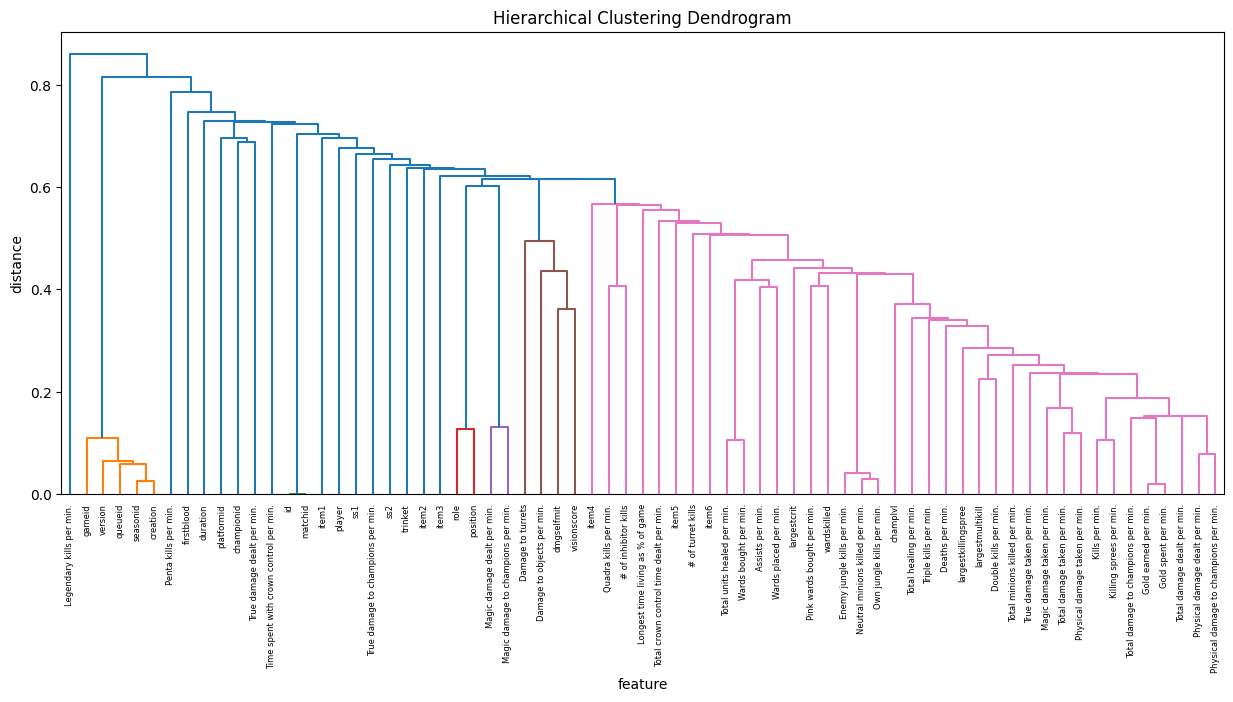

In [13]:
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(clustering_explainer._clustering, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

In [14]:
def create_partition_hierarchy(linkage_matrix, columns):
    def build_hierarchy(node, linkage_matrix, columns):
        if node < len(columns):
            return {columns[node]: columns[node]}
        else:
            left_child = int(linkage_matrix[node - len(columns), 0])
            right_child = int(linkage_matrix[node - len(columns), 1])
            left_subtree = build_hierarchy(left_child, linkage_matrix, columns)
            right_subtree = build_hierarchy(right_child, linkage_matrix, columns)
            return {f'cluster_{node}': {**left_subtree, **right_subtree}}
    
    root_node = len(linkage_matrix) + len(columns) - 1
    hierarchy = build_hierarchy(root_node, linkage_matrix, columns)
    return hierarchy[f'cluster_{root_node}']

In [15]:
clustering_tree = create_partition_hierarchy(clustering_explainer._clustering, X.columns)

In [16]:
clustering_tree

{'Legendary kills per min.': 'Legendary kills per min.',
 'cluster_135': {'cluster_79': {'gameid': 'gameid',
   'cluster_75': {'version': 'version',
    'cluster_74': {'queueid': 'queueid',
     'cluster_71': {'seasonid': 'seasonid', 'creation': 'creation'}}}},
  'cluster_134': {'Penta kills per min.': 'Penta kills per min.',
   'cluster_133': {'firstblood': 'firstblood',
    'cluster_132': {'duration': 'duration',
     'cluster_131': {'cluster_128': {'platformid': 'platformid',
       'cluster_126': {'championid': 'championid',
        'True damage dealt per min.': 'True damage dealt per min.'}},
      'cluster_130': {'Time spent with crown control per min.': 'Time spent with crown control per min.',
       'cluster_129': {'cluster_69': {'id': 'id', 'matchid': 'matchid'},
        'cluster_127': {'item1': 'item1',
         'cluster_125': {'player': 'player',
          'cluster_124': {'ss1': 'ss1',
           'cluster_123': {'True damage to champions per min.': 'True damage to champions

In [48]:
from itertools import chain, combinations, product

# gonna keep the n-ary tree in it's own class for easier referencing
class Node:
    def __init__(self, key):
        self.key = key
        self.child = []
        self.permutations = [] # this may not be the greatest idea??

    def __repr__(self):
        return f"({self.key}): {self.child} -> {self.permutations}"

# This function is to encode the dictionary to our specific structure
def build_tree(d, root):
    if isinstance(d, dict):
        for key, value in d.items():
            node = Node(key)
            root.child.append(node)
            build_tree(value, node)
    elif isinstance(d, list):
        for item in d:
            node = Node(item)
            root.child.append(node)
    # get all the sibling permutations
    generate_permutations(root)

#generate all permutations of sibling nodes and assign it to the nodes
def generate_permutations(node):
    if not node.child:  # Leaf node
        node.permutations = []
        return

    children_keys = [child.key for child in node.child]
    node.permutations = {}

    for i, child in enumerate(node.child):
        excluded = children_keys[:i] + children_keys[i + 1:]
        generate_permutations(child)

        # Generate all unique combinations of permutations for each child
        child.permutations = list(all_subsets(excluded))

def all_subsets(iterable):
    "Return all subsets of a given iterable."
    return chain.from_iterable(combinations(iterable, n) for n in range(len(iterable) + 1))


# Functions to generate the base masks for every node in the hierarchy
def get_all_leaf_values(node):
    leaves = []
    if not node.child:
        leaves.append(node.key)
    else:
        for child in node.child:
            leaves.extend(get_all_leaf_values(child))
    return leaves

def create_masks1(node, columns):
    masks = [np.zeros(len(columns),dtype=bool)] # not very efficient for huge trees? maybe??
    keys = [()]

    if not node.child:  # Check if the child list is empty
        mask = columns == node.key
        masks.append(mask)
        keys.append(node.key)
    else:
        # Create mask for current node
        current_node_mask = columns.isin(get_all_leaf_values(node))
        masks.append(current_node_mask)
        keys.append(node.key)

        # Recursively create masks for all child nodes
        for subset in node.child:
            child_masks, child_keys = create_masks1(subset, columns)
            masks.extend(child_masks)
            keys.extend(child_keys)

    return  masks, keys


# combine all the permutations along depth first traversal
def generate_paths_and_combinations(node):
    paths = []

    def dfs(current_node, current_path):
        current_path.append((current_node.key, current_node.permutations))

        if not current_node.child:  # Leaf node
            paths.append(current_path[:])  # Make a copy of current_path
        else:
            for child in current_node.child:
                dfs(child, current_path)

        current_path.pop()  # Backtrack

    dfs(node, [])

    combinations_list = []

    for path in paths:
        filtered_path = [(key, perms) for key, perms in path if perms]
        if filtered_path:
            node_keys, permutations = zip(*filtered_path)
            path_combinations = list(product(*permutations))
            last_key = node_keys[-1]
            for combination in path_combinations:
                combinations_list.append((last_key, combination))

    return combinations_list

# functions to combine the masks for all the permutations created
def combine_masks(masks):
    combined_mask = np.logical_or.reduce(masks)
    return combined_mask


# def create_combined_masks(combinations, masks_dict):
#     combined_masks = []
#     for last_key, combination in combinations:
#         masks = [masks_dict[key] for keys in combination for key in keys]
#         if masks:
#             combined_mask = combine_masks(masks)
#             combined_masks.append((last_key, combined_mask))

#             # Add the combined mask with the last key's mask
#             if last_key in masks_dict:
#                 combined_mask_with_last_key = combine_masks(masks + [masks_dict[last_key]])
#                 combined_masks.append((last_key, combined_mask_with_last_key))
#     return combined_masks


def create_combined_masks(combinations, masks_dict):
    combined_masks = []
    for last_key, combination in combinations:
        # Collect masks for each key in the combination
        masks = []
        for keys in combination:
            if isinstance(keys, tuple) and not keys:
                # Handle empty tuple (())
                continue
            for key in keys:
                if key in masks_dict:
                    masks.append(masks_dict[key])

        if masks:
            # Combine all the masks using logical OR
            combined_mask = combine_masks(masks)
            combined_masks.append((last_key, combined_mask))

            # Add the combined mask with the last key's mask if it's present
            if last_key in masks_dict:
                combined_mask_with_last_key = combine_masks(masks + [masks_dict[last_key]])
                combined_masks.append((last_key, combined_mask_with_last_key))
        else:
            # If no masks were found, create a mask of all False values
            combined_mask = np.zeros_like(list(masks_dict.values())[0])
            combined_masks.append((last_key, combined_mask))

            if last_key in masks_dict:
                combined_mask_with_last_key = combine_masks([combined_mask, masks_dict[last_key]])
                combined_masks.append((last_key, combined_mask_with_last_key))
    return combined_masks

In [ ]:
def generate_paths_and_combinations(node):
    paths = []

    def dfs(current_node, current_path):
        current_path.append((current_node.key, current_node.permutations))

        if not current_node.child:  # Leaf node
            paths.append(current_path[:])  # Make a copy of current_path
        else:
            for child in current_node.child:
                dfs(child, current_path)

        current_path.pop()  # Backtrack

    dfs(node, [])

    combinations_list = []

    for path in paths:
        filtered_path = [(key, perms) for key, perms in path if perms]
        if filtered_path:
            node_keys, permutations = zip(*filtered_path)
            path_combinations = list(product(*permutations))
            last_key = node_keys[-1]
            for combination in path_combinations:
                combinations_list.append((last_key, combination))

    return combinations_list

In [59]:
clustering_tree_remade = Node("Root")
build_tree(clustering_tree, clustering_tree_remade)

In [64]:
# generate_paths_and_combinations(clustering_tree_remade) this bit of the code eats up memory like crazy


KeyboardInterrupt



In [ ]:
# partition_explainer = shap.PartitionExplainer(predict, partition_masker, partition_tree=clustering_tree)
# start_time2 = time.time()
# winter_values = partition_explainer(Xv.iloc[:1,:])
# c

In [ ]:
partition_explainer.root

In [ ]:
winter_values

In [ ]:
clustering_winter_values 

In [ ]:
shap_values0 = explainer(Xv.iloc[1:,:])
fig, ax = plt.subplots()
shap.plots.waterfall(shap_values0[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

In [ ]:
fig, ax = plt.subplots()
shap.plots.waterfall(clustering_winter_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

In [ ]:
fig, ax = plt.subplots()
shap.plots.waterfall(winter_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

### Explain a single player's chances of winning a particular match

SHAP values sum to the difference between the expected output of the model and the current output for the current player. Note that for the Tree SHAP implementation the margin output of the model is explained, not the transformed output (such as a probability for logistic regression). This means that the units of the SHAP values for this model are log odds ratios. Large positive values mean a player is likely to win, while large negative values mean they are likely to lose.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0, :], Xv.iloc[0, :])

In [ ]:
xs = np.linspace(-4, 4, 100)
pl.xlabel("Log odds of winning")
pl.ylabel("Probability of winning")
pl.title("How changes in log odds convert to probability of winning")
pl.plot(xs, 1 / (1 + np.exp(-xs)))
pl.show()

### Summarize the impact of all features over the entire dataset

A SHAP value for a feature of a specific prediction represents how much the model prediction changes when we observe that feature. In the summary plot below we plot all the SHAP values for a single feature (such as `goldearned`) in a row, where the x-axis is the SHAP value (which for this model is in units of log odds of winning). By doing this for all features, we see which features drive the model's prediction a lot (such as `goldearned`), and which only effect the prediction a little (such as `kills`). Note that when points don't fit together on the line they pile up vertically to show density. Each dot is also colored by the value of that feature from high to low.

In [ ]:
shap.summary_plot(shap_values, Xv)

## Examine how changes in a feature change the model's prediction

The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all players we can see how changes in the feature's value effect the model's output. Note that these plots are very similar to standard partial dependence plots, but they provide the added advantage of displaying how much context matters for a feature (or in other words how much interaction terms matter). How much interaction terms effect the importance of a feature is captured by the vertical dispersion of the data points. For example earning only 100 gold/min during a game may lower your log odds of winning by 10 for some players or only 3 for others. Why is this? Because other features of these players effect how much earning gold matters for winning the game. Note that the vertical spread narrows once you earn at least 500 gold/min, meaning the context of other features matters less for high gold earners than low gold earners. We color the datapoints with another feature that most explains the interaction effect variance. For example earning less gold is less bad if you have not died very much, but it is really bad if you also die a lot.

The y-axis in the plots below represents the SHAP value for that feature, so -4 means observing that feature lowers your log odds of winning by 4, while a value of +2 means observing that feature raises your log odds of winning by 2.

Note that these plot just explain how the XGBoost model works, not nessecarily how reality works. Since the XGBoost model is trained from observational data, it is not nessecarily a causal model, and so just because changing a factor makes the model's prediction of winning go up, does not always mean it will raise your actual chances.

In [ ]:
shap.dependence_plot(
    "Gold earned per min.", shap_values, Xv, interaction_index="Deaths per min."
)

In [ ]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, Xv)